In [14]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact,interactive,interact_manual,fixed
import ipywidgets as widgets
%matplotlib inline

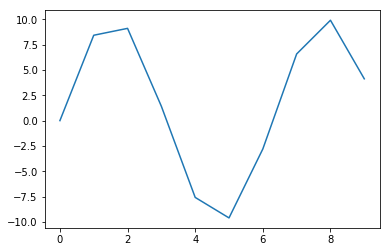

In [15]:
def f(A):
    plt.plot(np.arange(10),A*np.sin(np.arange(10)))

f(10)

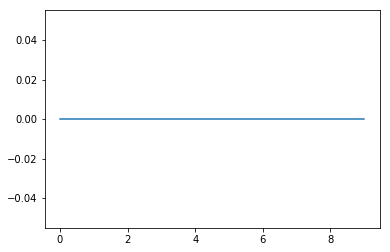

<function __main__.f(A)>

In [16]:
interact(f,A=(-1,1,0.5))